# Retrieval Augmented Diffusion Model for Time-Series Forecasting

# References

Paper: [**Retrieval-Augmented Diffusion Models for Time Series Forecasting**](https://openreview.net/pdf?id=dRJJt0Ji48)<br/>
Dataset: [**HouseTS Dataset from Kaggle**](https://www.kaggle.com/datasets/shengkunwang/housets-dataset)

# Project aim and paper description

The project aims to implement a generative model for time-series forecasting, applying it to a house-price and socioeconomic dataset. As demostrated in the paper, the model improves the general diffusion model framework by adding embedding-based retrieval mechanism that retrieves series sharing similar patterns from a reference database. It improves the model generation by exploiting the references, to overcome the lack of guidance in the forecasting process, leading to more accurate and context-aware forecasts.<br/>
In particular the framework proposed in the paper suggested to use a pre-trained encoder for time-series. The encoder compresses time-series, simplifying the task of finding series with similar patterns. It is also produced an index of the embeddings for a fast retrieval of the reference. </br> 

# Theoretical background and key concepts

Retrieval-Augmented Time-Series Diffusion (RATD) is based on the theory of diffusion probabilistic models, which are generative models that learn to reverse a Markovian forward noising process. These models are designed to learn the reverse of a forward noising process, where an original sample x0​ is progressively corrupted into xT​. <br/>

The model takes as input a time-series, where the tail of the series is completely filled with noise, and the model is able to recostruct the original signal, exploiting the context retrieved by the head of the series, the references and the side information.</br>

As previously described, the references were found by looking at the k-nearest neighbours in a lower dimensional space, with respect to the head of the series, and we take as references the tails of those neighbours. <br/>

The side information is obtained by concatenating the temporal embeddings with the feature embeddings, where the temporal embeddings are sinusoidal positional embeddings, while the feature embeddings are learnable positional embeddings.  

These embeddings are concatenated and fed into attention modules based on a Transformer architecture.

The model adopts a lightweight attention mechanism inspired by CSDI, consisting of alternating temporal and feature Transformer layers. By using linear attention, RATD is able to handle long sequences and large datasets more efficiently.

# Reproducibility

We both launched this notebook on our machines and on Kaggle notebooks. Before starting the process is required to import all the modules defined in the import section. It is also necessary to have available the auto-encoder for housets defined in the notebook "autoencoder_for_housets.ipynb". You can direclty find the pre-trained auto-encoder model in the folder "models", with the name "encoder.pth".

# Import

In [1]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 66.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install linear-attention-transformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-c

In [3]:
pip install torch_timeseries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 599.1 kB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 53.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 12.3 MB/s eta 0:00:00
  Created wheel for torch_timeseries: filename=torch_timeseries-0.1.10-py3-none-any.whl size=140280 sha256=14efeaa6fc1321a8af2b4ab0dbf05b1856b4ba1ca8c03af01b35ba60f8e1ac43
  Stored in directory: /root/.cache/pip/wheels/cc/1d/11/e1994b0a3efa97cfb326ff336da7fb4cde8c46c52e5bc901da
Successfully built torch_timeseries
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.8.2
    Uninstalling torchmetrics-1.8.2:
   

In [4]:
import torch
import torch.nn as nn
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from linear_attention_transformer import LinearAttentionTransformer
import math 
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import faiss
from IPython.display import display
import random
from sklearn.utils import shuffle

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # conflict between faiss and pytorch libraries 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Seed {seed}")

set_seed(42)

Seed 42


# Data extraction and preprocessing

In this section we extract the time series from the CSV file. <br/>
The original dataset contains entries of the form <date, median_sale_price, median_list_price, median_ppsf, median_list_ppsf, homes_sold, pending_sales, new_listings, inventory, median_dom, avg_sale_to_list, sold_above_list, off_market_in_two_weeks, city, zipcode, year, bank, bus, hospital, mall, park, restaurant, school, station, supermarket, Total Population, Median Age, Per Capita Income, Total Families Below Poverty, Total Housing Units, Median Rent,Median Home Value, Total Labor Force, Unemployed Population, Total School Age Population, Total School Enrollment, Median Commute Time, price, city_full>, where the combination of <zipcode, year> is a key for the dataset. 
The HouseTS dataset contains also satellite images, grouped by zipocode in different folders. For this reason we decided to keep only the entries relative to zones linked to images. 
The zipcode is a representative value for each zone of Washington.</br>
We extract time series of length of 24 steps (24 months), where our final aim is to predict the last 12 timesteps given the previous 12s. </br>
As preprocessing we dropped non relevant features in this simplified scenario, and we also extracted metadata: zipcode, timestamp, year.  

In [7]:
window_length = 168 + 192
step_size = 1

In [8]:
csv_file = "/kaggle/input/ettsmall/ETTm2.csv"
df = pd.read_csv(csv_file)

In [9]:
# 1. Order by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

def extract_windows(df, window_len, step):
    windows = []
    timestamps = []
    
    # Drop non-numeric columns for window extraction
    numeric_df = df.drop(columns=["date"])
    
    for i in range(step - 1, len(df) - window_len + 1, step):
        # Window of numeric features
        window = numeric_df.iloc[i:i+window_len].values
        windows.append(window)
        
        # Associate timestamps
        timestamps.append(df["date"].iloc[i:i+window_len].values)
    
    return np.array(windows), np.array(timestamps)

all_windows, all_timestamps = extract_windows(df, window_length, step_size)

X = all_windows  # shape: (num_samples, window_length, num_features)
meta_time = all_timestamps  # metadata: array of associated dates

print("Shape of X:", X.shape)               # (num_samples, window_length, num_features)
print("Shape of meta_time:", meta_time.shape)  # (num_samples, window_length)

Shape of X: (69321, 360, 7)
Shape of meta_time: (69321, 360)


We shuffled the dataset fixing the seed for replication purposes, then we splitted the dtaset for the training, evaluation and testing, respectively with a proportion 70%, 10% 20%. We normalized the datasets, according to the training dataset. Finally we created the DataLoaders, with a batch size of 32. 

In [10]:
# Ensure the dataframe is sorted by date
df["date"] = pd.to_datetime(df["date"])

# Define time boundaries
start_date = df["date"].min()
train_end = start_date + pd.DateOffset(months=12)
val_end = train_end + pd.DateOffset(months=4)
test_end = val_end + pd.DateOffset(months=4)

# Create masks for each split
train_mask = [all(d < train_end for d in window) for window in meta_time]
val_mask   = [all((d >= train_end) and (d < val_end) for d in window) for window in meta_time]
test_mask  = [all((d >= val_end) and (d < test_end) for d in window) for window in meta_time]

# Apply the masks
X_train = X[train_mask]
X_val   = X[val_mask]
X_test  = X[test_mask]

meta_train = [m for m, flag in zip(meta_time, train_mask) if flag]
meta_val   = [m for m, flag in zip(meta_time, val_mask) if flag]
meta_test  = [m for m, flag in zip(meta_time, test_mask) if flag]

print(len(X_train), len(X_val), len(X_test))

34681 11449 11161


In [11]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, meta, seq_len=None):
        self.X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        self.meta = meta
        self.seq_len = seq_len or X.shape[1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        meta_window = self.meta[idx]
        
        # Convert dates → UNIX timestamps
        timestamps = [int(pd.Timestamp(date).timestamp()) for date in meta_window]
        years = [pd.Timestamp(date).year for date in meta_window]
        
        return x, torch.tensor(timestamps, dtype=torch.long), torch.tensor(years, dtype=torch.long)


In [12]:
# Compute the statistics of the train dataset and normalize with respect to it 
mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape (1, 1, num_features)
std = X_train.std(axis=(0, 1), keepdims=True)

X_train_norm = (X_train - mean) / std
X_val_norm = (X_val - mean) / std
X_test_norm = (X_test - mean) / std

train_dataset = TimeSeriesDataset(X_train_norm, meta_train)
val_dataset = TimeSeriesDataset(X_val_norm, meta_val)
test_dataset = TimeSeriesDataset(X_test_norm, meta_test)

X_train_tensor =  train_dataset.X

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, generator=torch.Generator().manual_seed(42))

val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Mean Estimator

In [13]:
def build_x_mark_enc_vectorized(timestamps):
    """
    timestamps: tensor (B, T) of UNIX timestamps
    returns: tensor (B, T, 5) -> [minute, hour, weekday, day, month]
    """
    B, T = timestamps.shape
    x_mark = torch.zeros(B, T, 5)

    # Flatten, convert to datetime, then reshape
    ts_flat = timestamps.cpu().numpy().reshape(-1)
    ts_dt = pd.to_datetime(ts_flat, unit='s')

    # Extract features
    minute = torch.tensor(ts_dt.minute.values.reshape(B, T)) / 59.0
    hour   = torch.tensor(ts_dt.hour.values.reshape(B, T)) / 23.0
    weekday= torch.tensor(ts_dt.weekday.values.reshape(B, T)) / 6.0
    day    = torch.tensor(ts_dt.day.values.reshape(B, T)) / 31.0
    month  = torch.tensor(ts_dt.month.values.reshape(B, T)) / 12.0

    x_mark[:, :, 0] = minute
    x_mark[:, :, 1] = hour
    x_mark[:, :, 2] = weekday
    x_mark[:, :, 3] = day
    x_mark[:, :, 4] = month

    return x_mark.float()


In [14]:
try:
    from torch_timeseries.nn.Transformer_EncDec import Decoder, DecoderLayer, Encoder, EncoderLayer
except ImportError:
    Decoder = DecoderLayer = Encoder = EncoderLayer = None

try:
    from torch_timeseries.nn.SelfAttention_Family import DSAttention, AttentionLayer
except ImportError:
    DSAttention = AttentionLayer = None

try:
    from torch_timeseries.nn.embedding import DataEmbedding
except ImportError:
    DataEmbedding = None
    
class Projector(nn.Module):
    '''
    MLP to learn the De-stationary factors
    '''

    def __init__(self, input_dim, seq_len, hidden_dims, hidden_layers, output_dim, kernel_size=3):
        super(Projector, self).__init__()

        padding = kernel_size // 2
        self.series_conv = nn.Conv1d(in_channels=seq_len, out_channels=1, kernel_size=kernel_size, padding=padding,
                                     padding_mode='circular', bias=False)

        layers = [nn.Linear(2 * input_dim, hidden_dims[0]), nn.ReLU()]
        for i in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_dims[i], hidden_dims[i + 1]), nn.ReLU()]

        layers += [nn.Linear(hidden_dims[-1], output_dim, bias=False)]
        self.backbone = nn.Sequential(*layers)

    def forward(self, x, stats):
        # x:     B x T x D
        # stats: B x 1 x D
        # y:     B x O
        batch_size = x.shape[0]
        x = self.series_conv(x)  # B x 1 x D
        x = torch.cat([x, stats], dim=1)  # B x 2 x D
        x = x.view(batch_size, -1)  # B x 2D
        y = self.backbone(x)  # B x O

        return y

class MeanEstimator(nn.Module):
    """
    Non-stationary Transformer
    """

    def __init__(self,
                 seq_len: int,
                 pred_len: int,
                 input_dim: int,
                 window_size: int = 96,
                 d_model: int = 512,
                 n_heads: int = 8,
                 e_layers: int = 2,
                 d_layers: int = 1,
                 dropout: float = 0.1,
                 activation: str = "gelu",
                 embed: str = "learnable",
                 freq: str = "15T",
                 factor: int = 1,
                 output_attention: bool = False,
                 p_hidden_dims=(128, 128),
                 p_hidden_layers: int = 2,
                 beta_kl: float = 1e-3):  # coefficiente KL
        super(MeanEstimator, self).__init__()

        self.pred_len = pred_len
        self.seq_len = seq_len
        self.window_size = window_size
        self.beta_kl = beta_kl

        # 🔹 Conv1d front-end
        self.conv_in = nn.Conv1d(input_dim, d_model, kernel_size=3, padding=1)

        # Embedding
        self.enc_embedding = DataEmbedding(d_model, d_model, embed, freq, dropout)
        self.dec_embedding = DataEmbedding(d_model, d_model, embed, freq, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        DSAttention(False, factor, attention_dropout=dropout,
                                    output_attention=output_attention),
                        d_model, n_heads),
                    d_model,
                    d_model,
                    dropout=dropout,
                    activation=activation
                ) for _ in range(e_layers)
            ],
            norm_layer=nn.LayerNorm(d_model)
        )

        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        DSAttention(True, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        DSAttention(False, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_model,
                    dropout=dropout,
                    activation=activation,
                )
                for _ in range(d_layers)
            ],
            norm_layer=nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, input_dim, bias=True)
        )

        # Tau / Delta learners
        self.tau_learner = Projector(input_dim=input_dim, seq_len=seq_len,
                                     hidden_dims=p_hidden_dims,
                                     hidden_layers=p_hidden_layers,
                                     output_dim=1)
        self.delta_learner = Projector(input_dim=input_dim, seq_len=seq_len,
                                       hidden_dims=p_hidden_dims,
                                       hidden_layers=p_hidden_layers,
                                       output_dim=seq_len)

        # 🔹 Latent space con residual + dropout
        self.z_mean = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        self.z_logvar = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        self.z_out = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def kl_loss(self, mean, logvar):
        # KL divergence standard per VAE
        return -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + eps * std
        else:
            return mean

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None,
                return_kl=False):

        x_raw = x_enc.clone().detach()

        # 🔹 Normalization
        mean_enc = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - mean_enc
        std_enc = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-8).detach()
        x_enc = x_enc / std_enc

        # 🔹 Conv1d front-end
        x_enc = self.conv_in(x_enc.transpose(1, 2)).transpose(1, 2)

        # Decoder input
        x_dec_new = torch.cat(
            [x_enc[:, -self.window_size:, :],
             torch.zeros((x_enc.size(0), self.pred_len, x_enc.size(2)), device=x_enc.device)],
            dim=1
        )

        tau = self.tau_learner(x_raw, std_enc).exp()
        delta = self.delta_learner(x_raw, mean_enc)

        # Model Inference
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask, tau=tau, delta=delta)


        if return_kl:
            mu = self.z_mean(enc_out)
            logvar = self.z_logvar(enc_out)
        
        """z = self.reparameterize(mu, logvar)
        z = self.z_out(z)
        enc_out = enc_out + z  # residual injection"""

        dec_out = self.dec_embedding(x_dec_new, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask,
                               tau=tau, delta=delta)

        # De-normalization
        dec_out = dec_out * std_enc + mean_enc

        if return_kl:
            kl = self.kl_loss(mu, logvar)
            return dec_out[:, -self.pred_len:, :], dec_out, self.beta_kl * kl
        else:
            return dec_out[:, -self.pred_len:, :], dec_out


2025-10-29 16:03:11.138841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761753791.330456      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761753791.383453      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# ============================
# combined loss (MSE + MAE)
# ============================
def combined_loss(y_pred, y_true, mse_weight=1.0, mae_weight=0.2):
    mse = nn.MSELoss()(y_pred, y_true)
    mae = nn.L1Loss()(y_pred, y_true)
    return mse_weight * mse + mae_weight * mae, mse, mae

def train_mean_estimator(model, train_loader, val_loader, device, 
                         epochs=50, base_lr=1e-4, warmup_steps=1000):

    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))

    best_val_loss = float("inf")
    patience, patience_counter = 10, 0

    global_step = 0

    for epoch in range(epochs):
        model.train()
        train_mse_total = 0.0
        train_batches = 0

        for batch in train_loader:
            x, timestamps, _ = [b.to(device) for b in batch]

            x_enc = x[:, :model.seq_len, :].to(device).float()
            y_true = x[:, model.seq_len:, :].to(device).float()
            
            # Vectorized timestamp embedding
            timestamps_enc = timestamps[:, :model.seq_len]
            x_mark_enc = build_x_mark_enc_vectorized(timestamps_enc).to(device)
            
            x_dec = torch.zeros((x_enc.size(0), model.pred_len, x_enc.size(2)), device=device)
            x_mark_dec = torch.zeros((x_enc.size(0), model.pred_len + model.window_size, 5), device=device)

            optimizer.zero_grad()
            y_pred, _, kl = model(x_enc, x_mark_enc, x_dec, x_mark_dec, return_kl=True)

            # Reconstruction loss (MSE + MAE)
            loss_recon, mse, mae = combined_loss(y_pred, y_true)

            loss = loss_recon + kl

            # Backprop
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_mse_total += mse.item()
            train_batches += 1
            global_step += 1

        avg_train_mse = train_mse_total / train_batches

        # ============================
        # Validation
        # ============================
        model.eval()
        val_mse_total = 0.0
        val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                x, timestamps, _ = [b.to(device) for b in batch]

                x_enc = x[:, :model.seq_len, :].to(device).float()
                y_true = x[:, model.seq_len:, :].to(device).float()
                
                timestamps_enc = timestamps[:, :model.seq_len]
                x_mark_enc = build_x_mark_enc_vectorized(timestamps_enc).to(device)
                
                x_dec = torch.zeros((x_enc.size(0), model.pred_len, x_enc.size(2)), device=device)
                x_mark_dec = torch.zeros((x_enc.size(0), model.pred_len + model.window_size, 5), device=device)
    
                y_pred, _, _ = model(x_enc, x_mark_enc, x_dec, x_mark_dec, return_kl=True)

                _, mse_loss, _ = combined_loss(y_pred, y_true)
                val_mse_total += mse_loss.item()
                val_batches += 1

        avg_val_mse = val_mse_total / val_batches
        print(f"Epoch {epoch+1}/{epochs} | Train MSE: {avg_train_mse:.4f} | Val MSE: {avg_val_mse:.4f}")

        # ============================
        # Early stopping
        # ============================
        if avg_val_mse < best_val_loss:
            best_val_loss = avg_val_mse
            patience_counter = 0
            torch.save(model.state_dict(), "best_mean_estimator.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break


In [16]:
set_seed(42)

model = MeanEstimator(
    seq_len=168,          
    pred_len=192,         
    input_dim=7,          
    window_size=96,
    d_model=256,          
    n_heads=8,            
    e_layers=1,           
    d_layers=1,           
    dropout=0.1,         
    activation="gelu",
    embed="timeF",
    freq="t",
    factor=1,
    p_hidden_dims=(128, 128),  
    p_hidden_layers=2,
    beta_kl=0.1         
).to(device)

Seed 42


In [17]:
train_mean_estimator(model, train_loader, val_loader, device)

Epoch 1/50 | Train MSE: 0.2851 | Val MSE: 0.2066
Epoch 2/50 | Train MSE: 0.1841 | Val MSE: 0.2077
Epoch 3/50 | Train MSE: 0.1493 | Val MSE: 0.2051
Epoch 4/50 | Train MSE: 0.1324 | Val MSE: 0.2013
Epoch 5/50 | Train MSE: 0.1207 | Val MSE: 0.2134
Epoch 6/50 | Train MSE: 0.1116 | Val MSE: 0.2081
Epoch 7/50 | Train MSE: 0.1051 | Val MSE: 0.2053
Epoch 8/50 | Train MSE: 0.0995 | Val MSE: 0.2088
Epoch 9/50 | Train MSE: 0.0955 | Val MSE: 0.2025
Epoch 10/50 | Train MSE: 0.0920 | Val MSE: 0.2077
Epoch 11/50 | Train MSE: 0.0884 | Val MSE: 0.2078
Epoch 12/50 | Train MSE: 0.0858 | Val MSE: 0.2084
Epoch 13/50 | Train MSE: 0.0830 | Val MSE: 0.2072
Epoch 14/50 | Train MSE: 0.0814 | Val MSE: 0.2141
Early stopping triggered


# Sigma Estimator

In [17]:
def y_sigma(x, window_size=96, pred_len = 192):
    """
    Compute variance using a sliding window.
    Args:
    x (torch.Tensor): Input tensor (B, n + h, D).
    window_size (int): Sliding window size (default: 96).
    Returns:
    torch.Tensor: Variance tensor (B, h, N).
    """
    windows = x.unfold(1, window_size, 1) # Create sliding windows
    sigma = windows.var(dim=3, unbiased=False) # Compute variance
    return sigma[:, -pred_len:, :] # Extract output step variance

In [18]:
def wv_sigma_trailing(x, window_size):
    """
    Compute the variance over a trailing window for each time step.

    For each time step t, the variance is calculated over the window [t - window_size, t - 1].

    Args:
        x (Tensor): Input tensor of shape (B, n, D)
        window_size (int): Size of the trailing window

    Returns:
        sigma (Tensor): Variance tensor of shape (B, n, N)
    """

    B, n, D = x.shape

    if window_size < 1 or window_size > n:
        raise ValueError(f"window_size must be between 1 and T (got window_size={window_size}, n={n})")

    # Create sliding windows of size window_size along the T dimension
    # Each window will cover [t - window_size, t - 1] after padding
    # The resulting shape will be (B, n, window_size, D)
    windows = x.unfold(1, window_size + 1, 1) 

    # Compute variance across the window dimension (dim=2)
    sigma = windows.var(dim=3, unbiased=False)  # Shape: (B, n, D)
    return sigma

In [19]:
class SigmaEstimator(nn.Module):
    """
    Sigma Estimation module
    """
    def __init__(self, seq_len, pred_len, hidden_size=512, kernel_size=96):
        super(SigmaEstimator, self).__init__()
        self.pred_len = pred_len
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size  

        # 2-layer MLP for predicting future sigmas
        self.mlp = nn.Sequential(
            nn.Linear(seq_len - kernel_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, pred_len)   # outputs pred_len future sigmas
        )

    def forward(self, x):
        """
        x: (B, n, D)
        return: (B, pred_len, D)
        """
        B, n, D = x.shape

        # 1. Compute trailing sigma (moving variance/stddev)
        sigma = wv_sigma_trailing(x, self.kernel_size)   # -> (B, n - kernel_size, D)
        
        # 2. Predict future sigmas using MLP
        pred_sigma = self.mlp(sigma.permute(0, 2, 1))  # (B, D, n-kernel) -> (B, D, pred_len)

        # 3. Ensure positivity
        pred_sigma = F.softplus(pred_sigma)

        # 4. Reshape back to (B, pred_len, D)
        return pred_sigma.permute(0, 2, 1)

In [21]:
# Instantiate the Sigma Estimator
set_seed(42)

sigma_estimator = SigmaEstimator(seq_len = 168, pred_len = 192, hidden_size=32).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model parameters: {count_parameters(sigma_estimator):,}")

params = list(sigma_estimator.parameters())

optimizer = torch.optim.Adam(params, lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 100

patience = 10
patience_counter = 0

best_loss = 1e10

encoder_path = "sigma_estimator.pth"

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _, _  in loader:
            x = x.to(device)
            x_hat = model(x[:, :168, :])
            loss = loss_fn(x_hat, y_sigma(x))
            total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, epochs + 1):
    sigma_estimator.train()
    train_loss = 0

    for x, _, _ in train_loader:
        x = x.to(device)
        x_hat = sigma_estimator(x[:, :168, :])
        loss = loss_fn(x_hat, y_sigma(x))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss = evaluate(sigma_estimator, val_loader)
    test_loss = evaluate(sigma_estimator, test_loader)

    if val_loss + test_loss < best_loss:
        best_loss = val_loss + test_loss
        # Saves the weights
        torch.save(sigma_estimator.state_dict(), encoder_path)
        print("Models saved successfully.")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f} | Test MSE: {test_loss:.6f}")

Seed 42
Model parameters: 9,728
Models saved successfully.
Epoch 01 | Train MSE: 0.103732 | Val MSE: 0.006022 | Test MSE: 0.013690
Models saved successfully.
Epoch 02 | Train MSE: 0.072406 | Val MSE: 0.005824 | Test MSE: 0.013298
Epoch 03 | Train MSE: 0.070277 | Val MSE: 0.005964 | Test MSE: 0.013358
Models saved successfully.
Epoch 04 | Train MSE: 0.069011 | Val MSE: 0.005870 | Test MSE: 0.012921
Models saved successfully.
Epoch 05 | Train MSE: 0.068158 | Val MSE: 0.005737 | Test MSE: 0.013015
Models saved successfully.
Epoch 06 | Train MSE: 0.067515 | Val MSE: 0.005507 | Test MSE: 0.013024
Models saved successfully.
Epoch 07 | Train MSE: 0.066931 | Val MSE: 0.005531 | Test MSE: 0.012797
Epoch 08 | Train MSE: 0.066623 | Val MSE: 0.005701 | Test MSE: 0.012936
Epoch 09 | Train MSE: 0.066029 | Val MSE: 0.006530 | Test MSE: 0.013833
Epoch 10 | Train MSE: 0.065668 | Val MSE: 0.005545 | Test MSE: 0.013173
Models saved successfully.
Epoch 11 | Train MSE: 0.065236 | Val MSE: 0.005441 | Test M

# Model

In this section we developed the RATD model according to the descriptions and the graphical representations reported in the paper.</br> </br>
<img src="ratd_architecture.png"> </br></br>
We started from the implementation of the module regarding the side information (time embeddings + feature embeddings) and the diffusion timestep embeddings. 
Then we implemented the other blocks lik the RMA (Reference Modulated Attention) module, the Time and the Feature Tranformers, starting from the implementation provived by LinearAttentionTransformer, and finally the GAU (Gated Activation Unit) module. </br>
We composed all together these blocks in the module RATDLayer, that includes all the computations done in a single step of the model. Lastly we implemented the complete RATD model, by stacking the layers and applying additonal computations adding the noise to the input, initializing the side information and the diffiusion timestep embedding, and finally processing the results of each layer.    

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
def compute_tilde_alpha(alpha: torch.Tensor) -> torch.Tensor:
    alpha = alpha.float()
    n = alpha.shape[0]
    tilde_alpha = torch.zeros_like(alpha)  
    
    for t in range(n):
        slice_t = alpha[:t+1].flip(dims=[0])
        cprod = torch.cumprod(slice_t, dim=0)
        tilde_alpha[t] = cprod.sum()
    return tilde_alpha

def compute_hat_alpha(alpha: torch.Tensor) -> torch.Tensor:
    alpha = alpha.float()
    n = alpha.shape[0]
    hat_alpha = torch.zeros_like(alpha)  
    for t in range(n):
        slice_t = alpha[:t+1].flip(dims=[0]) # at, at-1, at-2, ...
        cprod = torch.cumprod(slice_t, dim=0) # at, at-1*at, at-1*at-2*at, ...
        cprod = cprod * slice_t # at^2, at-1^2*at, at-1*at-2^2*at, ...
        hat_alpha[t] = cprod.sum()
    return hat_alpha

In [22]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        # out = gamma.view(-1, self.num_out) * out

        out = gamma.view(t.size()[0], -1, self.num_out) * out
        return out


class ConditionalGuidedModel(nn.Module):
    def __init__(self, diff_steps, enc_in):
        super(ConditionalGuidedModel, self).__init__()
        n_steps = diff_steps + 1
        
        data_dim = enc_in * 3 #if self.cat_y_pred else MTS_args.enc_in
        self.lin1 = ConditionalLinear(data_dim, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, enc_in)
        self.sigma_lin = nn.Linear(128, enc_in)

    def forward(self, x, y_t, y_0_hat, g_x, t):
        
        # return eps_pred : noise  (B, O, N)
        #        sigma: variance   (B, O, N)
        
        eps_pred = torch.cat((y_t, y_0_hat, g_x), dim=-1)
        eps_pred = F.softplus(self.lin1(eps_pred, t))
        eps_pred = F.softplus(self.lin2(eps_pred, t))
        eps_pred = F.softplus(self.lin3(eps_pred, t))
        eps_pred, sigma = self.lin4(eps_pred), F.softplus(self.sigma_lin(F.softplus(eps_pred))) # sigma 
        return eps_pred, sigma 

In [23]:
def make_beta_schedule(schedule="linear", num_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == "linear":
        betas = torch.linspace(start, end, num_timesteps)
    elif schedule == "const":
        betas = end * torch.ones(num_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, num_timesteps) ** 2
    elif schedule == "jsd":
        betas = 1.0 / torch.linspace(num_timesteps, 1, num_timesteps)
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, num_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    elif schedule == "cosine" or schedule == "cosine_reverse":
        max_beta = 0.999
        cosine_s = 0.008
        betas = torch.tensor(
            [min(1 - (math.cos(((i + 1) / num_timesteps + cosine_s) / (1 + cosine_s) * math.pi / 2) ** 2) / (
                    math.cos((i / num_timesteps + cosine_s) / (1 + cosine_s) * math.pi / 2) ** 2), max_beta) for i in
             range(num_timesteps)])
        if schedule == "cosine_reverse":
            betas = betas.flip(0)  # starts at max_beta then decreases fast
    elif schedule == "cosine_anneal":
        betas = torch.tensor(
            [start + 0.5 * (end - start) * (1 - math.cos(t / (num_timesteps - 1) * math.pi)) for t in
             range(num_timesteps)])
    return betas

In [24]:
import yaml
import argparse

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

def compute_gx_term(alpha: torch.Tensor) -> torch.Tensor:
    alpha = alpha.float()
    n = alpha.shape[0]
    gx_term = torch.zeros_like(alpha)  
    for t in range(n):
        slice_t = alpha[:t+1].flip(dims=[0]) # at, at-1, at-2, a1
        cprod = torch.cat([torch.tensor([1]).to(slice_t.device), torch.cumprod(slice_t, dim=0)])
        cprod = cprod[:-1] * ((1 - slice_t)**2) # at^2, at-1^2*at, at-1*at-2^2*at, ...
        gx_term[t] = cprod.sum()
    return gx_term

class NsDiff(nn.Module):
    """
    Vanilla Transformer
    """

    def __init__(self, configs, device):
        super(NsDiff, self).__init__()

        self.args = configs
        self.device = device

        # self.model_var_type = configs.var_type
        self.num_timesteps = configs.timesteps
        self.dataset_object = None
        betas = make_beta_schedule(schedule=configs.beta_schedule, num_timesteps=configs.timesteps,
                                   start=configs.beta_start, end=configs.beta_end)
        betas = self.betas = betas.float().to(self.device)
        self.betas_sqrt = torch.sqrt(betas)
        alphas = 1.0 - betas
        self.alphas = alphas
        self.one_minus_betas_sqrt = torch.sqrt(alphas)
        alphas_cumprod = alphas.to('cpu').cumprod(dim=0).to(self.device)
        self.alphas_cumprod = alphas_cumprod
        self.alphas_bar_sqrt = torch.sqrt(alphas_cumprod)
        
        self.betas_bar = 1 - self.alphas_cumprod
        # self.alphas_cumprod_sum = torch.cumsum(alphas_cumprod.flip(0), dim=0).flip(0)
        self.alphas_cumprod_sum = compute_tilde_alpha(alphas)
        
        self.alphas_tilde = self.alphas_cumprod_sum
        self.alphas_hat = compute_hat_alpha(alphas).to(self.device)
        self.betas_tilde = self.alphas_tilde  - self.alphas_hat
        self.gx_term = compute_gx_term(alphas).to(self.device) # full compute to avoid precision issue
        # import pdb;pdb.set_trace()
        assert (torch.tensor(self.betas_tilde) >= 0).all()
        # import pdb;pdb.set_trace(), ((self.betas_bar - self.betas_tilde)[((self.betas_bar - self.betas_tilde)>=0)])
        assert ((self.betas_bar - self.betas_tilde)>=0).all()
        # (self.betas_bar - self.betas_tilde)[((self.betas_bar - self.betas_tilde)>0)]
        
        
        self.betas_tilde_m_1 = torch.cat(
            [torch.ones(1, device=self.device), self.betas_tilde[:-1]], dim=0
        )
        self.betas_bar_m_1 = torch.cat(
            [torch.ones(1, device=self.device), self.betas_bar[:-1]], dim=0
        )

        
        self.one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_cumprod)
        if configs.beta_schedule == "cosine":
            self.one_minus_alphas_bar_sqrt *= 0.9999  # avoid division by 0 for 1/sqrt(alpha_bar_t) during inference
        alphas_cumprod_prev = torch.cat(
            [torch.ones(1, device=self.device), alphas_cumprod[:-1]], dim=0
        )
        self.alphas_cumprod_sum_prev = torch.cat(
            [torch.ones(1, device=self.device), self.alphas_cumprod_sum[:-1]], dim=0
        )

        self.alphas_cumprod_prev = alphas_cumprod_prev
        self.posterior_mean_coeff_1 = (
                betas * torch.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_mean_coeff_2 = (
                torch.sqrt(alphas) * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)
        )
        posterior_variance = (
                betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = posterior_variance
        # if self.model_var_type == "fixedlarge":
        #     self.logvar = betas.log()
        #     # torch.cat(
        #     # [posterior_variance[1:2], betas[1:]], dim=0).log()
        # elif self.model_var_type == "fixedsmall":
        #     self.logvar = posterior_variance.clamp(min=1e-20).log()

        self.tau = None  # precision fo test NLL computation

        # CATE MLP
        self.diffussion_model = ConditionalGuidedModel(configs.timesteps, configs.enc_in)

        self.enc_embedding = DataEmbedding(configs.enc_in, configs.CART_input_x_embed_dim, configs.embed, configs.freq,
                                           configs.dropout)


    def forward(self, x, x_mark, y_t, y_0_hat, gx, t):
        enc_out = self.enc_embedding(x, x_mark) #  B, T, d_model
        dec_out, sigma = self.diffussion_model(enc_out, y_t, y_0_hat, gx, t)

        return dec_out, sigma

In [26]:
from types import SimpleNamespace

class NsDiffExp(nn.Module):
    def __init__(self, input_dim, original_len, seq_len):
        super().__init__()
        self.t_len = 20
        self.original_len = original_len
        self.seq_len = seq_len
        self.input_dim = input_dim
        
        # Diffusion parameters
        beta_start = 1e-4
        beta_end = 0.02

        configs = SimpleNamespace(
            timesteps=self.t_len,
            beta_schedule="linear",
            beta_start=beta_start,
            beta_end=beta_end,
            enc_in=self.input_dim,
            CART_input_x_embed_dim=32,
            embed="learnable",
            freq="15T",
            dropout=0.05,
        )

        self.mu_estimator =  model = MeanEstimator(
            seq_len=168,          
            pred_len=192,         
            input_dim=7,          
            window_size=96,
            d_model=256,          
            n_heads=8,            
            e_layers=1,           
            d_layers=1,           
            dropout=0.1,         
            activation="gelu",
            embed="timeF",
            freq="t",
            factor=1,
            p_hidden_dims=(128, 128),  
            p_hidden_layers=2,
            beta_kl=0.1         
        )

        self.model = NsDiff(configs, device).to(device)

        self.mu_estimator.load_state_dict(torch.load("/kaggle/working/best_mean_estimator.pth"))
        
        self.sigma_estimator = SigmaEstimator(seq_len = original_len, 
            pred_len = seq_len, 
            hidden_size=32
        )

        self.sigma_estimator.load_state_dict(torch.load("/kaggle/working/sigma_estimator.pth"))

        for param in self.mu_estimator.parameters():
            param.requires_grad = False
        
        for param in self.sigma_estimator.parameters():
            param.requires_grad = False

    def forecast(self, x, x_mark, y_t, y_0_hat, gx, t):
        return self.model(x, x_mark, y_t, y_0_hat, gx, t)

    def calc_loss(self, x0, timestamps, t=None):
        eps = 1e-8
        B, T, D = x0.shape
        device = x0.device
        original_T = self.original_len
    
        # 1. Draw timestep t u.a.r
        if t is None:
            t = random.randint(1, self.t_len - 1)
        t_tensor = torch.full((B,), t, dtype=torch.long, device=device)
    
        # Diffusion parameters for timestep t
        alpha_t        = self.model.alphas_cumprod[t].view(-1, 1, 1)
        beta_t         = self.model.betas[t].view(-1, 1, 1)
        alpha_scalar   = self.model.alphas[t].view(-1, 1, 1)
        beta_bar_tm1   = self.model.betas_bar[t - 1].view(-1, 1, 1)
        beta_tilde_tm1 = self.model.betas_tilde[t - 1].view(-1, 1, 1)
    
        timestamps_enc = timestamps[:, :original_T]
        x_mark_enc = build_x_mark_enc_vectorized(timestamps_enc).to(device)
    
        x_dec      = torch.zeros((B, self.seq_len, D), device=device)
        x_mark_dec = torch.zeros((B, self.seq_len + self.mu_estimator.window_size, 5), device=device)
    
        # 2. Mean and sigma
        mean_x, _ = self.mu_estimator(x0[:, :original_T, :], x_mark_enc, x_dec, x_mark_dec)
        sigma_x   = torch.clamp(self.sigma_estimator(x0[:, :original_T, :]), min=eps, max=1e3)
        y_sigma_x0 = torch.clamp(y_sigma(x0), min=eps, max=1e3)
    
        # 3. Build sigma_bar_t
        alpha_vec = (self.model.betas_bar[t] - self.model.betas_tilde[t]).view(-1, 1, 1)
        beta_vec  = self.model.betas_tilde[t].view(-1, 1, 1)
        sigma_bar_t = alpha_vec * sigma_x + beta_vec * y_sigma_x0
        sigma_bar_t = torch.clamp(sigma_bar_t, min=eps, max=1e3)
    
        # 4. Draw Yt
        yt   = x0[:, original_T:, :]
        noise = torch.randn_like(yt)
        noise = sigma_bar_t.sqrt() * noise
        yt_noisy = (alpha_t.sqrt()) * yt + (1 - alpha_t.sqrt()) * mean_x + noise
    
        # 6. Noise prediction
        noise_pred, sigma_pred = self.forecast(x0[:, :original_T, :], x_mark_enc, yt_noisy, mean_x, sigma_x, t_tensor)
        sigma_pred = torch.clamp(sigma_pred, min=eps, max=1e3)
    
        # 7. Compute sigma_tilde
        sigma_tilde_num = (beta_t**2 * sigma_x + alpha_scalar * beta_t * y_sigma_x0) * \
                          ((beta_bar_tm1 - beta_tilde_tm1) * sigma_x + beta_tilde_tm1 * y_sigma_x0)
        sigma_tilde_den = sigma_x * (alpha_scalar * beta_bar_tm1 - alpha_scalar * beta_tilde_tm1 + beta_t**2) + \
                          y_sigma_x0 * (alpha_scalar * beta_tilde_tm1 + alpha_scalar * self.model.betas[t].view(-1,1,1))
        sigma_tilde = sigma_tilde_num / (sigma_tilde_den + eps)
        sigma_tilde = torch.clamp(sigma_tilde, min=eps, max=1e3)
    
        # 8. Loss
        mse_loss = ((noise - noise_pred).square()).mean()
    
        ratio = (sigma_tilde + eps) / (sigma_pred + eps)
        ratio = torch.clamp(ratio, min=eps, max=1e6)
        # var_loss = (ratio - torch.log(ratio) - 1).mean()
        var_loss = (ratio - torch.log(ratio)).mean()
    
        kl = mse_loss + var_loss
        # loss = loss1 + loss2 + kl
        loss = kl
    
        return loss

    def forward(self, x, timestamps, n_samples=1):
        eps = 1e-8
        B, T, D = x.shape
        device = x.device
        original_T = self.original_len
    
        # 1. Timestamp embedding
        timestamps_enc = timestamps[:, :original_T]
        x_mark_enc = build_x_mark_enc_vectorized(timestamps_enc).to(device)
    
        x_dec = torch.zeros((B, self.seq_len, D), device=device)
        x_mark_dec = torch.zeros((B, self.seq_len + self.mu_estimator.window_size, 5), device=device)
    
        # 2. Mu and sigma estimations
        with torch.no_grad():
            mean_x, _ = self.mu_estimator(x[:, :original_T, :], x_mark_enc, x_dec, x_mark_dec)
            sigma_x = torch.clamp(self.sigma_estimator(x[:, :original_T, :]), min=eps, max=1e3)
    
            b_stack = torch.empty((n_samples, B, self.seq_len, D), device=x.device)
    
            for i in range(n_samples):
                # Draw Yt from N(f(x), g(x))
                Yt = mean_x + sigma_x.sqrt() * torch.randn_like(mean_x)
    
                for t in reversed(range(1, self.t_len)):
                    t_tensor = torch.full((B,), t, dtype=torch.long, device=device)
                
                    # Diffusion parameters
                    alpha_bar_t     = self.model.alphas_cumprod[t]
                    alpha_bar_t_1   = self.model.alphas_cumprod[t - 1]
                    
                    beta_t          = self.model.betas[t]
                    beta_bar_t_1    = self.model.betas_bar[t - 1]
                    beta_tilde_t_1  = self.model.betas_tilde[t - 1]
                    
                    beta_bar_t      = self.model.betas_bar[t]
                    beta_tilde_t    = self.model.betas_tilde[t]
                    
                    alpha_t         = self.model.alphas_cumprod[t].view(-1, 1, 1)
                
                    # Noise z if t > 1
                    z = torch.randn_like(Yt) if t > 1 else None
                
                    # Noise prediction
                    noise_pred, sigma_pred = self.forecast(x[:, :original_T, :], x_mark_enc, Yt, mean_x, sigma_x, t_tensor)
                    sigma_pred = torch.clamp(sigma_pred, min=eps, max=1e3)
                
                    # Debug
                    debug_tensors = {
                        "alpha_bar_t": alpha_bar_t,
                        "alpha_bar_t_1": alpha_bar_t_1,
                        "beta_t": beta_t,
                        "beta_bar_t_1": beta_bar_t_1,
                        "beta_tilde_t_1": beta_tilde_t_1,
                        "beta_bar_t": beta_bar_t,
                        "beta_tilde_t": beta_tilde_t,
                        "alpha_t": alpha_t,
                        "sigma_x": sigma_x,
                        "sigma_pred": sigma_pred,
                        "Yt_before": Yt,
                    }
                
                    for name, tensor in debug_tensors.items():
                        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
                            print(f"[NaN/Inf detected BEFORE step t={t}] {name}: {tensor}")
                            return torch.full_like(x, float("nan"))
                
                    # Compute λ0, λ1, λ2
                    lambda0 = torch.clamp(alpha_t * beta_t * beta_tilde_t_1, min=eps, max=1e3)
                    sigma_theta = sigma_pred
                    lambda1 = (beta_t**2 * beta_tilde_t_1 +
                               alpha_t * beta_t * (beta_bar_t_1 - beta_tilde_t_1) * sigma_x -
                               sigma_theta * (alpha_t * beta_tilde_t_1 + alpha_t * beta_t))
                    lambda2 = (sigma_x**2 * beta_t**2 * (beta_bar_t_1 - beta_tilde_t_1) -
                               sigma_theta * sigma_x * (alpha_t * beta_bar_t_1 - alpha_t * beta_tilde_t_1 + beta_t**2))
                
                    lambda1 = torch.clamp(lambda1, min=-1e6, max=1e6)
                    lambda2 = torch.clamp(lambda2, min=-1e6, max=1e6)
                
                    discriminant = lambda1**2 - 4*lambda0*lambda2
                    discriminant = torch.clamp(discriminant, min=0.0, max=1e12)
                    sigma_hat_Y0 = (-lambda1 + torch.sqrt(discriminant)) / (2*lambda0 + eps)
                    sigma_hat_Y0 = torch.clamp(sigma_hat_Y0, min=eps, max=1e3)
                
                    term1 = (Yt - (1 - torch.sqrt(alpha_bar_t)) * mean_x -
                             torch.sqrt(torch.clamp((beta_bar_t - beta_tilde_t) * sigma_x +
                             beta_tilde_t * sigma_hat_Y0, min=0.0)) * noise_pred)
                    term1 = torch.clamp(term1, min=-1e6, max=1e6)
                    Y_hat_0 = term1 / torch.clamp(torch.sqrt(alpha_bar_t), min=eps)
                    Y_hat_0 = torch.clamp(Y_hat_0, min=-1e6, max=1e6)
                
                    # Debug
                    debug_tensors_post = {
                        "lambda0": lambda0,
                        "lambda1": lambda1,
                        "lambda2": lambda2,
                        "discriminant": discriminant,
                        "sigma_hat_Y0": sigma_hat_Y0,
                        "term1": term1,
                        "Y_hat_0": Y_hat_0,
                    }
                
                    for name, tensor in debug_tensors_post.items():
                        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
                            print(f"[NaN/Inf detected AFTER step t={t}] {name}: {tensor}")
                            return torch.full_like(x, float("nan"))
                
                    # Update Y_{t-1}
                    if t > 1:
                        sigma_t = ((1 - self.model.alphas[t]) ** 2) * sigma_x + (1 - self.model.alphas[t]) * self.model.alphas[t] * sigma_hat_Y0
                        sigma_bar_t_1 = (beta_bar_t_1 - beta_tilde_t_1) * sigma_x + beta_tilde_t_1 * sigma_hat_Y0
                        denom = torch.clamp(self.model.alphas[t] * sigma_bar_t_1 + sigma_t, min=eps)
                
                        gamma0 = torch.sqrt(alpha_bar_t_1) * sigma_t / denom
                        gamma1 = torch.sqrt(self.model.alphas[t]) * sigma_bar_t_1 / denom
                        gamma2_num = (torch.sqrt(self.model.alphas[t]) * (self.model.alphas[t] - 1) * sigma_bar_t_1 +
                                      (1 - torch.sqrt(alpha_bar_t_1)) * sigma_t)
                        gamma2 = gamma2_num / denom
                
                        Yt.copy_(gamma0 * Y_hat_0 + gamma1 * Yt + gamma2 * mean_x +
                                 torch.sqrt(torch.clamp(sigma_pred, min=0.0)) * z)
                    else:
                        Yt.copy_(Y_hat_0)
                
                    # Debug Yt
                    if torch.isnan(Yt).any() or torch.isinf(Yt).any():
                        print(f"[NaN/Inf detected AFTER update t={t}] Yt: {Yt}")
                        return torch.full_like(x, float("nan"))
    
                b_stack[i] = Yt
    
            Yt = b_stack.mean(dim=0)
            return torch.cat([x[:, :original_T, :], Yt], dim=1), Yt, b_stack

In [27]:
for xb, timestamps, _ in train_loader:
  break
xb = xb.to(device)
timestamps = timestamps.to(device)

In [28]:
print(xb.shape, timestamps.shape)

torch.Size([32, 360, 7]) torch.Size([32, 360])


In [29]:
# test
B, orig_len, D = 32, 168, 7
K = 3
C = 4
side_dim = 48
emb_dim = 16
T = 192

model = NsDiffExp(
    input_dim=D,
    original_len=orig_len,
    seq_len=T
).to(device)

xb, timestamps = xb.to(device), timestamps.to(device) 

output, _, _ = model(xb, timestamps)

"""print(output)

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    out = model(xb[:, 0:orig_len, :], xr)

print(prof.key_averages().table(sort_by="cuda_time_total"))"""

assert output.shape == (B, orig_len + T, D), f"Output shape mismatch: {output.shape}"
print("Test passed: output shape", output.shape)

/tmp/ipykernel_37/3378436465.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert (torch.tensor(self.betas_tilde) >= 0).all()


Test passed: output shape torch.Size([32, 360, 7])


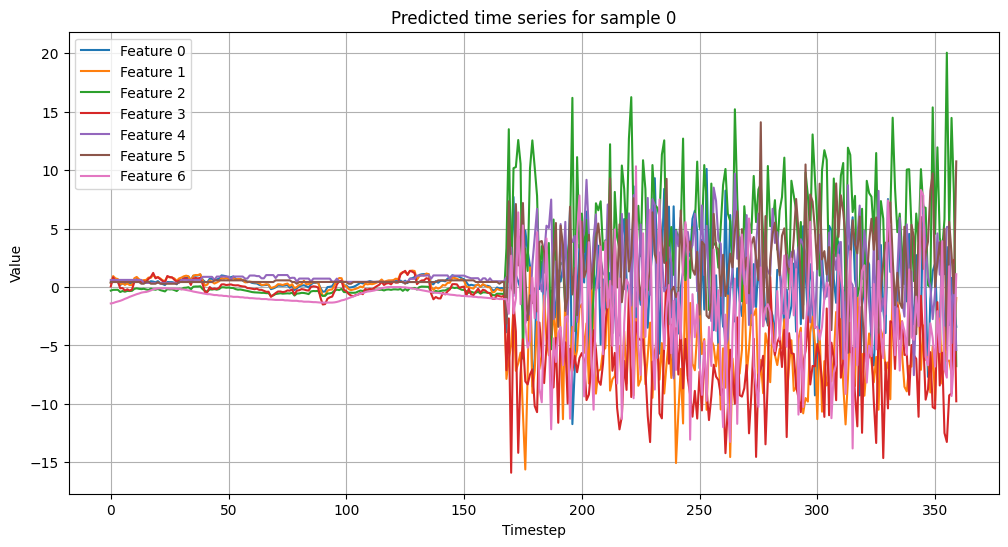

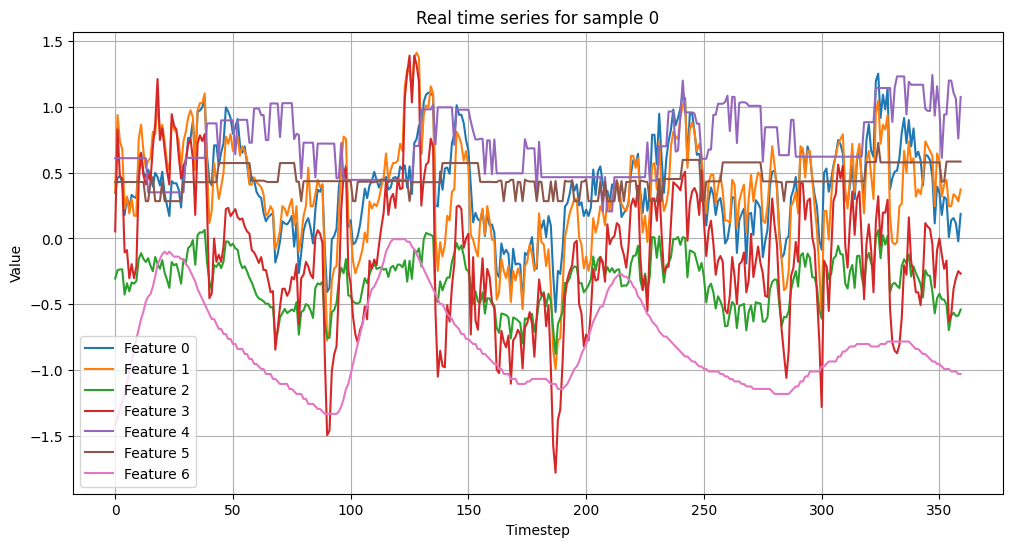

In [30]:
# x: (B, T, D)
sample_idx = 0
x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()


# Training

In [32]:
# training function with early stopping

def train_nsdiff(
    model,
    train_loader,
    val_loader=None,
    epochs=10,
    lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='best_model.pt',
    patience=10
):
    orig_len = model.original_len
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-8
    )
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    start_epoch = 1
    epochs_no_improve = 0  # contatore per early stopping

    # === Recover Checkpoint ===
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        torch.set_rng_state(checkpoint['rng_state'])
        torch.cuda.set_rng_state_all(checkpoint['cuda_rng_state'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint found. Restart from epoch {start_epoch} with best_val_loss {best_val_loss:.6f}.")

    for epoch in range(start_epoch, epochs + 1):
        model.train()
        train_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
        for x, timestamps, _ in pbar:
            # retrieve the top-k similar series
            x, timestamps = x.to(device), timestamps.to(device)

            optimizer.zero_grad()
            loss = model.calc_loss(x, timestamps)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}")

        # === VALIDATION ===
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, timestamps, _ in val_loader:
                    x, timestamps = x.to(device), timestamps.to(device)
                    pred = model(x, timestamps)
                    loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch}: Val MSE = {avg_val_loss:.6f}")

            scheduler.step(avg_val_loss)

            # === Check improvement for early stopping ===
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_val_loss': best_val_loss,
                    'rng_state': torch.get_rng_state(),
                    'cuda_rng_state': torch.cuda.get_rng_state_all()
                }, save_path)
                print(f"Saved best model at {save_path}")
            else:
                epochs_no_improve += 1

            # === Early Stopping ===
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch} epochs. Best Val Loss = {best_val_loss:.6f}")
                break

In [33]:
B, orig_len, D = 32, 168, 7
T = 192

set_seed(42)

model = NsDiffExp(
    input_dim=D,
    original_len=orig_len,
    seq_len=T
).to(device)

Seed 42


/tmp/ipykernel_37/3378436465.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert (torch.tensor(self.betas_tilde) >= 0).all()


In [34]:
train_nsdiff(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=1e-3,
    epochs=10,
    save_path='models/best_nsdiff.pt',
)

Epoch 1 [Train]: 100%|██████████| 1084/1084 [01:08<00:00, 15.91it/s, loss=1.61]


Epoch 1: Train Loss = 1.828731
Epoch 1: Val MSE = 0.354533
Saved best model at models/best_nsdiff.pt


Epoch 2 [Train]: 100%|██████████| 1084/1084 [01:08<00:00, 15.89it/s, loss=1.35]


Epoch 2: Train Loss = 1.507842
Epoch 2: Val MSE = 0.358805


Epoch 3 [Train]: 100%|██████████| 1084/1084 [01:08<00:00, 15.85it/s, loss=1.43]


Epoch 3: Train Loss = 1.426855
Epoch 3: Val MSE = 0.363797


Epoch 4 [Train]: 100%|██████████| 1084/1084 [01:08<00:00, 15.88it/s, loss=1.32]


Epoch 4: Train Loss = 1.390266
Epoch 4: Val MSE = 0.352491
Saved best model at models/best_nsdiff.pt


Epoch 5 [Train]: 100%|██████████| 1084/1084 [01:08<00:00, 15.84it/s, loss=1.36]


Epoch 5: Train Loss = 1.360769
Epoch 5: Val MSE = 0.355759


Epoch 6 [Train]: 100%|██████████| 1084/1084 [01:08<00:00, 15.92it/s, loss=1.3] 


Epoch 6: Train Loss = 1.332521
Epoch 6: Val MSE = 0.355912


Epoch 7 [Train]: 100%|██████████| 1084/1084 [01:09<00:00, 15.64it/s, loss=1.4] 


Epoch 7: Train Loss = 1.320921
Epoch 7: Val MSE = 0.358552


Epoch 8 [Train]: 100%|██████████| 1084/1084 [01:09<00:00, 15.58it/s, loss=1.36]


Epoch 8: Train Loss = 1.303478
Epoch 8: Val MSE = 0.357894


Epoch 9 [Train]: 100%|██████████| 1084/1084 [01:08<00:00, 15.91it/s, loss=1.2] 


Epoch 9: Train Loss = 1.297363
Epoch 9: Val MSE = 0.355795


Epoch 10 [Train]: 100%|██████████| 1084/1084 [01:08<00:00, 15.85it/s, loss=1.33]


Epoch 10: Train Loss = 1.293476
Epoch 10: Val MSE = 0.358393


# Results

In [31]:
B, orig_len, D = 32, 168, 7
T = 192

model = NsDiffExp(
    input_dim=D,
    original_len=orig_len,
    seq_len=T
).to(device)

/tmp/ipykernel_37/3378436465.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert (torch.tensor(self.betas_tilde) >= 0).all()


In [32]:
checkpoint = torch.load("/kaggle/working/models/best_nsdiff.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

NsDiffExp(
  (mu_estimator): MeanEstimator(
    (conv_in): Conv1d(7, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (enc_embedding): DataEmbedding(
      (value_embedding): TokenEmbedding(
        (tokenConv): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
      )
      (position_embedding): PositionalEmbedding()
      (temporal_embedding): TimeFeatureEmbedding(
        (embed): Linear(in_features=5, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (dec_embedding): DataEmbedding(
      (value_embedding): TokenEmbedding(
        (tokenConv): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
      )
      (position_embedding): PositionalEmbedding()
      (temporal_embedding): TimeFeatureEmbedding(
        (embed): Linear(in_features=5, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (attn_layer

In [34]:
loss = 0
for xb, timestamps, _ in test_loader:
    
    # xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
    xb, timestamps= xb.to(device), timestamps.to(device)
    # output = model(xb, timestamps, xr, n_samples = 1)
    alt_output, _, _ = model(xb, timestamps, n_samples = 100)
    loss += nn.MSELoss()(alt_output[:, 168:, :], xb[:, 168:, :])
    break
print(loss)

tensor(0.1388, device='cuda:0')


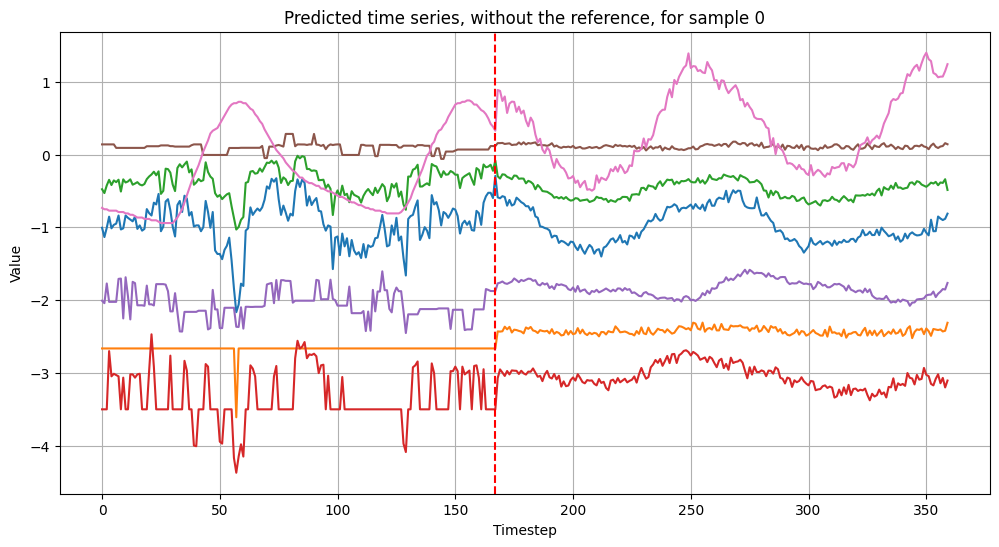

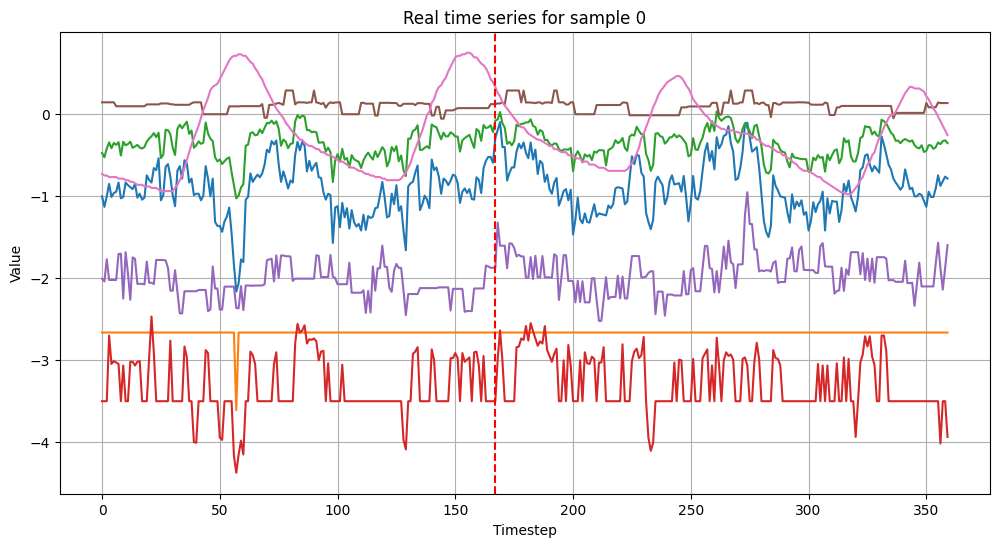

In [35]:
# x: (B, T, D)
#for sample_idx in range(B):
sample_idx = 0    
x_sample = alt_output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series, without the reference, for sample {sample_idx}")
plt.axvline(x=orig_len - 1, color='red', linestyle='--')
plt.grid(True)
plt.show()

"""x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.axvline(x=orig_len - 1, color='red', linestyle='--')
plt.grid(True)
plt.show()
"""

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.axvline(x=orig_len - 1, color='red', linestyle='--')
plt.grid(True)
plt.show()

The visual and statistical (0.084 vs 0.143 of MSE) results acknowledge the improvement brought by the guidance of a reference during the generation process.

In [36]:
class QICE(nn.Module):
    """
    Quantile Interval Coverage Error (QICE)
    """
    def __init__(self, n_bins: int = 10):
        super().__init__()
        self.n_bins = n_bins
        self.register_buffer("quantile_bin_counts", torch.zeros(n_bins))
        self.register_buffer("total_samples", torch.tensor(0, dtype=torch.long))

    @torch.no_grad()
    def update(self, preds: torch.Tensor, targets: torch.Tensor):
        """
        Updates the QICE state given a batch of predictions and targets.

        Args:
            preds: Tensor of shape (B, seq_len, D, S) or (S, B, seq_len, D)
                - S: number of generated samples per forecast
                - B: batch size
                - seq_len: forecast horizon
                - D: number of variables (features)
            targets: Tensor of shape (B, seq_len, D)
        """
        # Ensure predictions are in shape (N, S)
        if preds.shape[0] != targets.numel():  # if shape is (S, B, T, D)
            preds = preds.permute(1, 2, 3, 0)  # -> (B, T, D, S)
        preds = preds.reshape(-1, preds.shape[-1])  # (N, S)
        targets = targets.reshape(-1)               # (N,)

        preds_np = preds.cpu().numpy()
        targets_np = targets.cpu().numpy()

        # 1. Compute quantile boundaries
        quantile_edges = np.linspace(0, 100, self.n_bins + 1)
        y_pred_quantiles = np.percentile(preds_np, q=quantile_edges, axis=1).T  # (N, n_bins + 1)

        # 2. Determine which quantile bin each target belongs to
        membership = ((targets_np[:, None] - y_pred_quantiles) > 0).astype(int)
        y_true_bin_index = membership.sum(axis=1)  # range [0, n_bins + 1]

        # 3. Count how many targets fall into each quantile interval
        counts = np.array([(y_true_bin_index == v).sum() for v in np.arange(self.n_bins + 2)])

        # Merge outliers (<0% and >100%) into first and last bins
        counts[1] += counts[0]
        counts[-2] += counts[-1]
        counts = counts[1:-1]  # keep only valid bins

        # 4. Update cumulative statistics
        self.quantile_bin_counts += torch.tensor(counts, dtype=torch.float32, device=preds.device)
        self.total_samples += preds.shape[0]

    def compute(self):
        """
        Compute the final QICE score as the mean absolute deviation
        between the ideal uniform coverage and the empirical coverage.
        """
        ratios = self.quantile_bin_counts / self.total_samples.float()
        assert torch.abs(ratios.sum() - 1) < 1e-5, "Quantile coverage ratios must sum to 1!"
        ideal = torch.ones_like(ratios) / self.n_bins
        qice = torch.mean(torch.abs(ideal - ratios))
        return qice


In [37]:
class CRPS(nn.Module):
    """
    Continuous Ranked Probability Score (CRPS)
    """

    def __init__(self):
        super().__init__()
        self.register_buffer("total_crps", torch.tensor(0.0))
        self.register_buffer("total_samples", torch.tensor(0, dtype=torch.long))

    @torch.no_grad()
    def update(self, preds: torch.Tensor, targets: torch.Tensor):
        """
        Args:
            preds: Tensor of predicted samples, shape (S, B, T, D)
            targets: Tensor of ground-truth values, shape (B, T, D)
        """
        preds = preds.permute(1, 2, 3, 0)
        preds = preds.reshape(-1, preds.shape[-1])  # (M, S)
        targets = targets.reshape(-1, 1)         # (M, 1)
        
        # |X - y|
        abs_diff_data = torch.abs(preds - targets)  # (M, S)
        term1 = abs_diff_data.mean(dim=1)           # E|X - y|

        # |X - X'|
        pairwise_diffs = torch.abs(preds.unsqueeze(2) - preds.unsqueeze(1))  # (M, S, S)
        term2 = 0.5 * pairwise_diffs.mean(dim=(1, 2))                        # 0.5 * E|X - X'|

        crps = term1 - term2  # (M,)
        self.total_crps += crps.sum()
        self.total_samples += preds.shape[0]

    def compute(self):
        """Return the average CRPS across all samples."""
        return self.total_crps / self.total_samples


In [38]:
set_seed(42)
mse_fn = nn.MSELoss()
mae_fn = nn.L1Loss()
crps = CRPS().to(device)
qice = QICE().to(device)

test_mse = 0.0
test_mae = 0.0

with torch.no_grad():
    for xb, timestamps, _ in test_loader:
        xb, timestamps = xb.to(device), timestamps.to(device)
        
        # forward pass
        _, y_pred, pred_samples = model(xb, timestamps, n_samples=100)
        y_true = xb[:, orig_len:, :]  # true future
        
        # deterministic metrics
        test_mse += mse_fn(y_pred, y_true).item()
        test_mae += mae_fn(y_pred, y_true).item()
        
        # probabilistic metrics
        crps.update(pred_samples, y_true)
        qice.update(pred_samples, y_true)

# aggregate results
avg_test_mse = test_mse / len(test_loader)
avg_test_mae = test_mae / len(test_loader)
avg_test_crps = crps.compute().item()
avg_test_qice = qice.compute().item()

Seed 42


In [39]:
print(f"Test MSE:  {avg_test_mse:.6f}")
print(f"Test MAE:  {avg_test_mae:.6f}")
print(f"Test CRPS: {avg_test_crps:.6f}")
print(f"Test QICE: {avg_test_qice:.6f}")

Test MSE:  0.349906
Test MAE:  0.387671
Test CRPS: 0.291257
Test QICE: 0.026343


# Final Considerations

The results obtained in our experiments are promising and show comparable performance to those reported in the reference paper. Specifically, despite working with a similar number of features, our model achieved prediction errors in a similar range, indicating that our architecture and preprocessing pipeline were effective. While we attempted to replicate the experimental conditions as closely as possible, including the use of publicly available platforms such as Kaggle for training, it is important to note that we did not have access to the same computational resources as the original study. This limitation may have affected training duration, batch size, and model complexity. Nevertheless, the similarity in the results suggests that our implementation closely resembles the original approach, both in design and in effectiveness, reinforcing the validity of our experimental setup.